# Predictable t-SNE

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is not a transformer which can produce outputs for other inputs than the one used to train the transform. The proposed solution is train a predictor afterwards to try to use the results on some other inputs the model never saw.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## t-SNE on MNIST

Let's reuse some part of the example of [Manifold learning on handwritten digits: Locally Linear Embedding, Isomap…](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py).

In [3]:
import numpy
from sklearn import datasets

digits = datasets.load_digits(n_class=6)
Xd = digits.data
yd = digits.target
imgs = digits.images
n_samples, n_features = Xd.shape
n_samples, n_features

(1083, 64)

Let's split into train and test.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, imgs_train, imgs_test = train_test_split(Xd, yd, imgs)

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)

X_train_tsne = tsne.fit_transform(X_train, y_train)
X_train_tsne.shape

(812, 2)

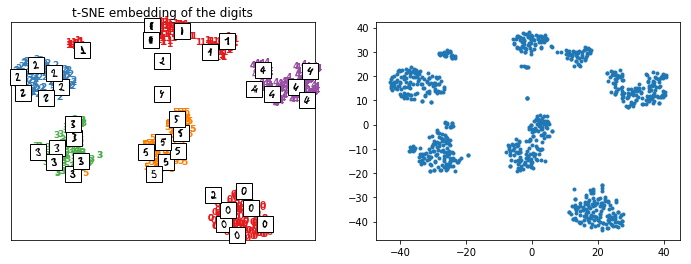

In [6]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox

def plot_embedding(Xp, y, imgs, title=None, figsize=(12, 4)):
    x_min, x_max = numpy.min(Xp, 0), numpy.max(Xp, 0)
    X = (Xp - x_min) / (x_max - x_min)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i in range(X.shape[0]):
        ax[0].text(X[i, 0], X[i, 1], str(y[i]),
                   color=plt.cm.Set1(y[i] / 10.),
                   fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = numpy.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = numpy.sum((X[i] - shown_images) ** 2, 1)
            if numpy.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = numpy.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r),
                X[i])
            ax[0].add_artist(imagebox)
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[1].plot(Xp[:, 0], Xp[:, 1], '.')
    if title is not None:
        ax[0].set_title(title)
    return ax
        
plot_embedding(X_train_tsne, y_train, imgs_train, "t-SNE embedding of the digits");

## Repeatable t-SNE

We use class *PredictableTSNE* but it works for other trainable transform too.

In [7]:
from mlinsights.mlmodel import PredictableTSNE
ptsne = PredictableTSNE()
ptsne.fit(X_train, y_train)

c:\python370_x64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


PredictableTSNE(e_activation='relu', e_alpha=0.0001, e_batch_size='auto',
        e_beta_1=0.9, e_beta_2=0.999, e_early_stopping=False,
        e_epsilon=1e-08, e_hidden_layer_sizes=(100,),
        e_learning_rate='constant', e_learning_rate_init=0.001,
        e_max_iter=200, e_momentum=0.9, e_n_iter_no_change=10,
        e_nesterovs_momentum=True, e_power_t=0.5, e_random_state=None,
        e_shuffle=True, e_solver='adam', e_tol=0.0001,
        e_validation_fraction=0.1, e_verbose=False, e_warm_start=False,
        t_angle=0.5, t_early_exaggeration=12.0, t_init='random',
        t_learning_rate=200.0, t_method='barnes_hut', t_metric='euclidean',
        t_min_grad_norm=1e-07, t_n_components=2, t_n_iter=1000,
        t_n_iter_without_progress=300, t_perplexity=30.0,
        t_random_state=None, t_verbose=0)

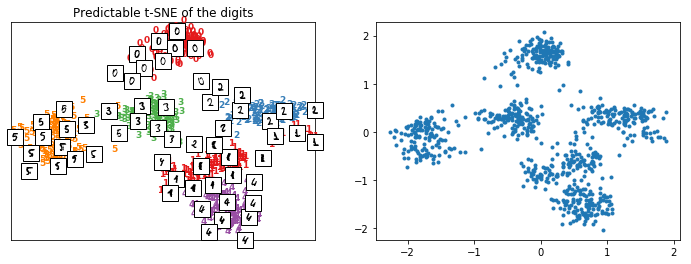

In [8]:
X_train_tsne2 = ptsne.transform(X_train)
plot_embedding(X_train_tsne2, y_train, imgs_train, "Predictable t-SNE of the digits");

The difference now is that it can be applied on new data.

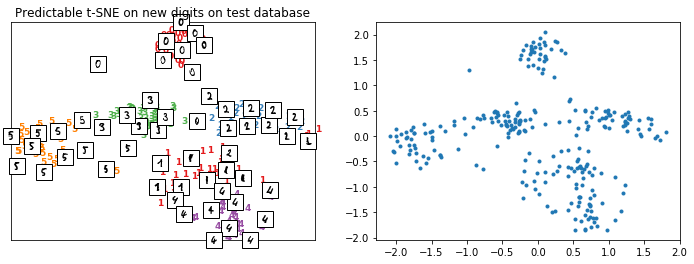

In [9]:
X_test_tsne2 = ptsne.transform(X_test)
plot_embedding(X_test_tsne2, y_test, imgs_test, "Predictable t-SNE on new digits on test database");

By default, the output data is normalized to get comparable results over multiple tries such as the *loss* computed between the normalized output of *t-SNE* and their approximation.

In [10]:
ptsne.loss_

0.024681568435970355

## Repeatable t-SNE with another predictor

The predictor is a [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).

In [11]:
ptsne.estimator_

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Let's replace it with a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) and a normalizer [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
ptsne_knn = PredictableTSNE(normalizer=StandardScaler(),
                            estimator=KNeighborsRegressor())
ptsne_knn.fit(X_train, y_train)

PredictableTSNE(e_algorithm='auto', e_leaf_size=30, e_metric='minkowski',
        e_metric_params=None, e_n_jobs=None, e_n_neighbors=5, e_p=2,
        e_weights='uniform', n_copy=True, n_with_mean=True,
        n_with_std=True, t_angle=0.5, t_early_exaggeration=12.0,
        t_init='random', t_learning_rate=200.0, t_method='barnes_hut',
        t_metric='euclidean', t_min_grad_norm=1e-07, t_n_components=2,
        t_n_iter=1000, t_n_iter_without_progress=300, t_perplexity=30.0,
        t_random_state=None, t_verbose=0)

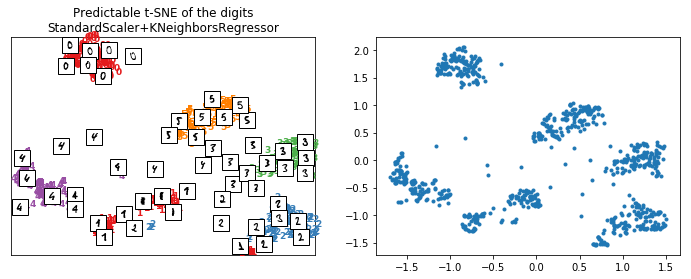

In [13]:
X_train_tsne2 = ptsne_knn.transform(X_train)
plot_embedding(X_train_tsne2, y_train, imgs_train,
               "Predictable t-SNE of the digits\nStandardScaler+KNeighborsRegressor");

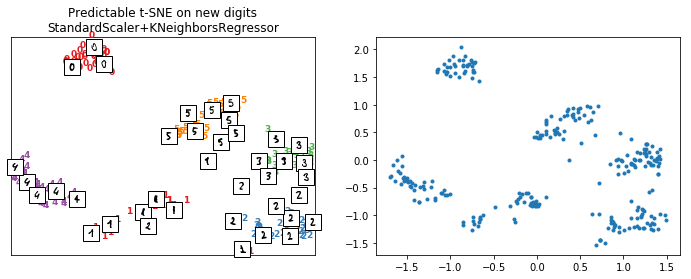

In [14]:
X_test_tsne2 = ptsne_knn.transform(X_test)
plot_embedding(X_test_tsne2, y_test, imgs_test,
               "Predictable t-SNE on new digits\nStandardScaler+KNeighborsRegressor");

The model seems to work better as the loss is better but as it is evaluated on the training dataset, it is just a way to check it is not too big.

In [15]:
ptsne_knn.loss_

0.004112159